In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter
import copy
from sklearn.linear_model import LinearRegression
import netCDF4
import rioxarray
import xarray as xr
import statsmodels.api as sm
from shapely.geometry import mapping
import datetime

In [5]:
#2000-2019年中国湖泊时序重构数据集
China_Lakes_time_series=pd.read_csv(r'1_data\lake area time series_2000-2019_China.csv').dropna()
China_Lakes_time_series

,GLAKES_ID,Year,Reservoir_flag,Area_raw,Area_dr
0,44,2000,0,151.452703,1211.170476
1,44,2001,0,1030.693554,1210.341072
2,44,2002,0,472.115406,1210.310305
3,44,2003,0,1212.516327,1214.170653
4,44,2004,0,1207.558202,1212.641128
...,...,...,...,...,...
143575,192203,2015,0,0.978261,0.979147
143576,192203,2016,0,0.956111,0.956259
143577,192203,2017,0,0.931747,0.931747
143578,192203,2018,0,0.915504,0.915947


In [2]:
six_region=gpd.read_file(r'1_data\CN_div6_wgs84.shp')

In [3]:
proj = ccrs.LambertConformal(central_longitude=105, 
                              central_latitude=40,
                              standard_parallels=(25.0, 47.0))
lw=[0.25,0.5,0.8,1,2] #line width (px)
fs=[8,12,14] #font size (px)
plt.rc('font',family='Arial', size=fs[0])
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
colors = {0:'#EEDD82', 1:'#D8BFD8', 2:'#FFB5C5', 3:'#EE6363',4:'#F4A460',5:'#90EE90'}
regions=['EP','MP','XJ','NE','YG','TP']

Text(0, 0.5, 'lake area ($km^2$)')

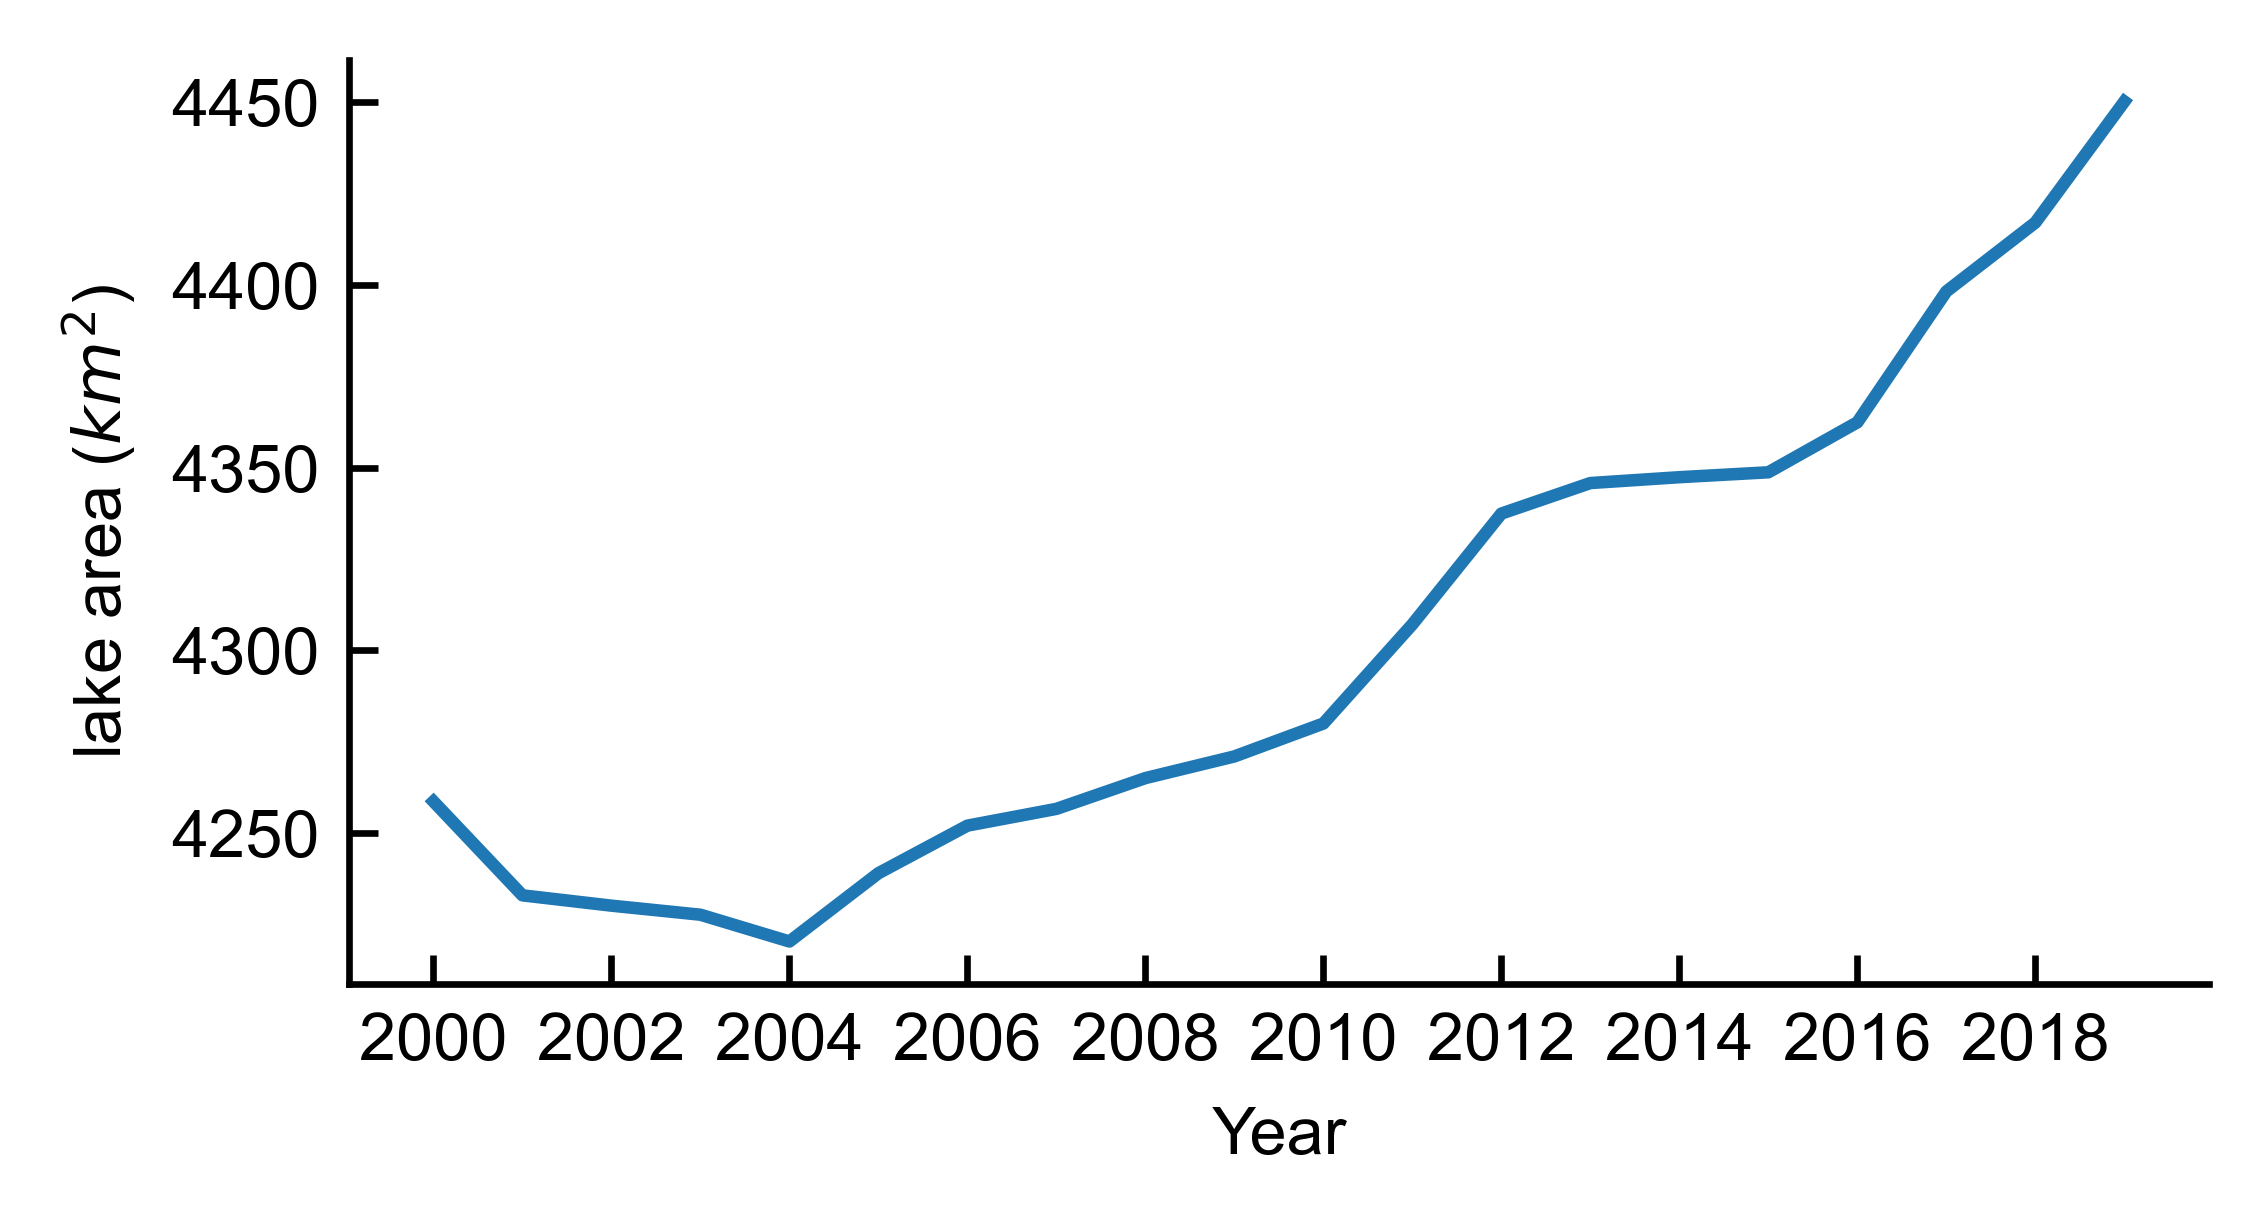

In [6]:
lake_id=46
fig = plt.figure(figsize=(4,2), dpi=600)
ax = plt.axes()
xtic=np.arange(2000,2020,2)
lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
lake_time_series.plot(x='Year',y='Area_dr',ax=ax,xticks=xtic,legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('lake area ($km^2$)')

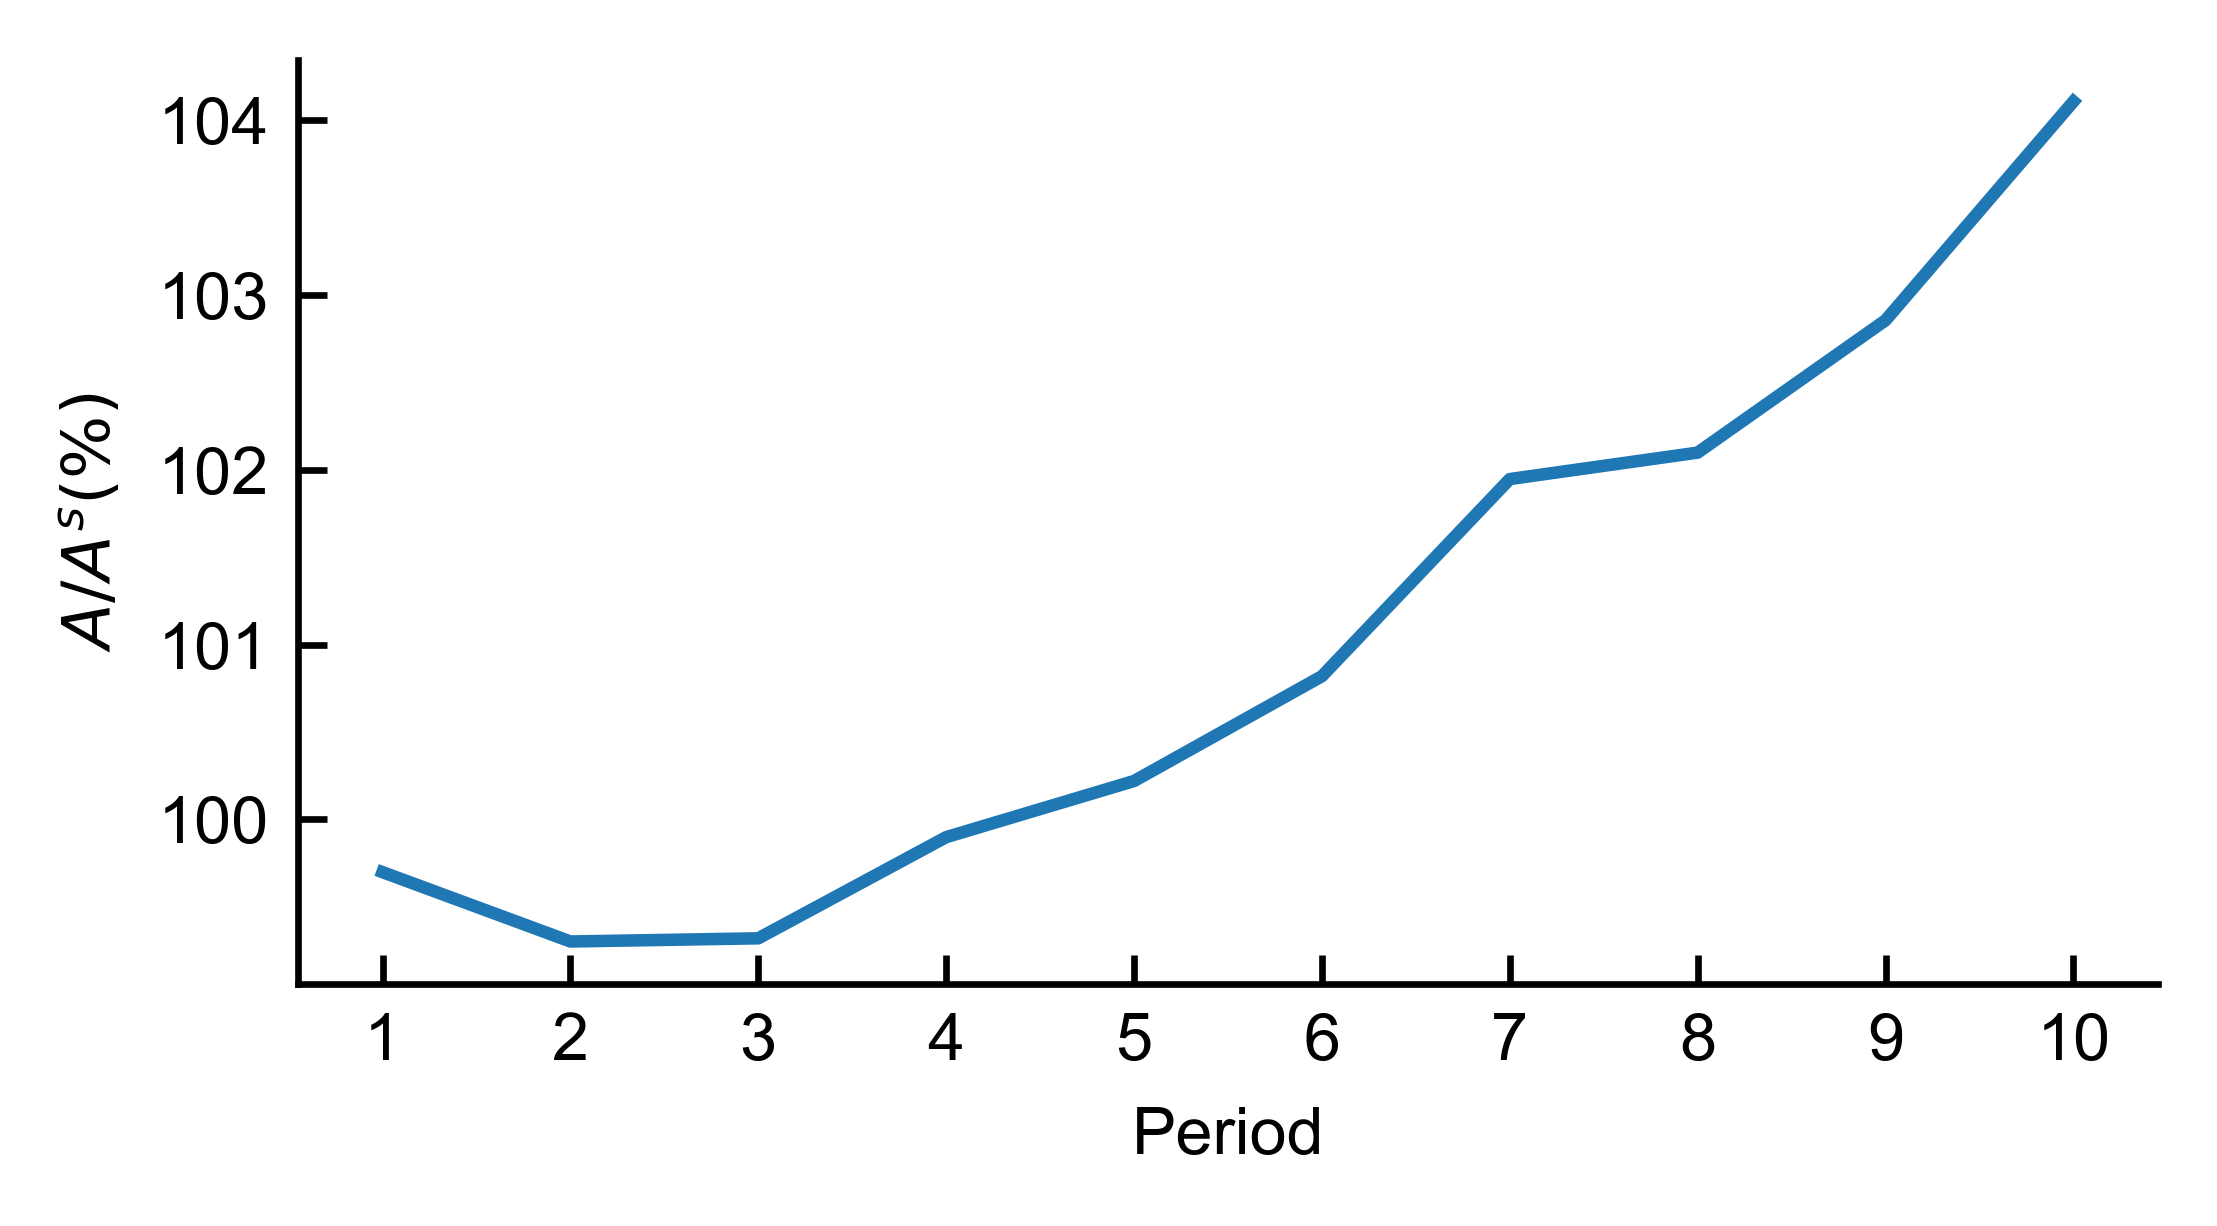

In [6]:
# lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
fig = plt.figure(figsize=(4,2), dpi=600)
ax = plt.axes()
lake_change=[]
lake_change=[]
if (lake_time_series.iloc[0]['Year']<2002) & (lake_time_series.iloc[0]['Area_dr']>10):
    As=lake_time_series.iloc[0]['Area_dr']
    lake_time_series['Ai']=lake_time_series['Area_dr']/As*100
                #five period
    for i in np.arange(2000,2020,2):
        period=lake_time_series[lake_time_series['Year'].map(lambda x: x>=i and x<i+2)]['Ai'].mean()
        lake_change.append(period)
# print(lake_change)
xtic=np.arange(1,11)
plt.plot(xtic,lake_change)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$A/A^s (\%)$')
ax.set_xlabel('Period')
ax.set_xticks(xtic)

## 处理气候数据

In [7]:
pre_2018=xr.open_dataset('2_climate_data\pre_2018.nc', engine="netcdf4")
pre_2018

<xarray.Dataset>
Dimensions:  (lon: 7849, lat: 5146, time: 12)
Coordinates:
  * lon      (lon) float64 71.29 71.3 71.31 71.32 ... 136.7 136.7 136.7 136.7
  * lat      (lat) float64 58.63 58.62 58.61 58.61 ... 15.78 15.77 15.76 15.76
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    pre      (time, lat, lon) float32 ...

In [7]:
pre_s=xr.open_dataset('2_climate_data\pre_2001.nc', engine="netcdf4")
pre_s

<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 12)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 13.0 14.0 15.0 16.0 17.0 ... 21.0 22.0 23.0 24.0
Data variables:
    pre      (time, lat, lon) float32 ...

<xarray.DataArray 'pre' (time: 12)>
[12 values with dtype=float32]
Coordinates:
    lon      float64 100.2
    lat      float64 36.89
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    long_name:  monthly precipitation
    unit:       0.1 mm


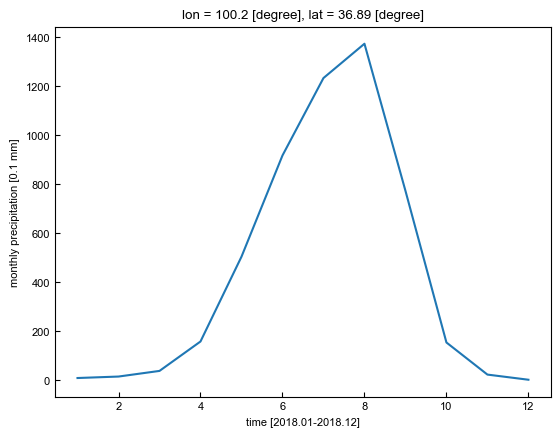

In [11]:
x=pet_2018.pre.sel(lon=100.2,lat=36.89,method='nearest')
print(x)
x.plot()

In [6]:
nc_files = [f for f in os.listdir('data') if f.startswith('pre')]
year_start=2000
for fn in nc_files:
    ds=xr.open_dataset('data\\'+fn, engine="netcdf4")
    print(ds)
    for y in range(0,3):
        da=ds.sel(time=slice(1+y*12,12+y*12))
        print(da)
        da.to_netcdf('2_climate_data\pre_{}.nc'.format(year_start))
        year_start=year_start+1
#     else:
#         da=ds.pre.sum('time')/10
#         da=da.assign_coords(time=year_start) 
#         da_list.append(da)
#         year_start=year_start+1
# da_list
# ds

<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 36)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    pre      (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 12)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    pre      (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 12)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float

<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 12)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 25.0 26.0 27.0 28.0 29.0 ... 33.0 34.0 35.0 36.0
Data variables:
    pre      (time, lat, lon) float32 ...


In [4]:
nc_files = [f for f in os.listdir('data') if f.startswith('tmp')]
year_start=2000
for fn in nc_files:
    ds=xr.open_dataset('data\\'+fn, engine="netcdf4")
    print(ds)
    for y in range(0,3):
        da=ds.sel(time=slice(1+y*12,12+y*12))
#         print(da)
        da.to_netcdf('tmp_{}.nc'.format(year_start))
        year_start=year_start+1

<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 36)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    tmp      (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 36)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    tmp      (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lon: 7680, lat: 4717, time: 36)
Coordinates:
  * lon      (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2 136.2
  * lat      (lat) float64 55.55 55.55 55.54 55.53 ... 16.28 16.27 16.26 16.25
  * time     (time) flo

In [25]:
da_list
year_start=2000
for da in da_list:
    da.to_netcdf('2_climate_data\pre_{}.nc'.format(year_start))
    year_start=year_start+1

In [9]:
# ds=xr.open_dataset('2_climate_data\\pre_2000_2002.nc', engine="netcdf4")
# ds.pre.sel(time=slice(13,24))
ds=xr.open_dataset('2_climate_data\\pet_2000.nc', engine="netcdf4")
ds
# ds.pre.sel(time=slice(13,24))

<xarray.Dataset>
Dimensions:  (lon: 7849, lat: 5146, time: 12)
Coordinates:
  * lon      (lon) float64 71.29 71.3 71.31 71.32 ... 136.7 136.7 136.7 136.7
  * lat      (lat) float64 58.63 58.62 58.61 58.61 ... 15.78 15.77 15.76 15.76
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    etp      (time, lat, lon) float32 ...

In [5]:
# 指定文件夹路径
combined_ds = xr.concat(da_list, dim="time")
# 保存合并后的数据集为nc文件
output_file = "pre_sum.nc"
combined_ds.to_netcdf(output_file)

In [5]:
all_files=[]
for root, dirs, files in os.walk('2_climate_data'):
    for file in files:
        if file.endswith('.nc')and file.startswith('pet'):
             all_files.append(os.path.join(root, file))
print(all_files)

da_list=[]
year_start=2000
for fn in all_files:
    ds=xr.open_dataset(fn, engine="netcdf4")
    da=ds.etp.sum('time')/10
    da=da.assign_coords(time=year_start) 
    da_list.append(da)
    year_start=year_start+1
da_list
# ds

['2_climate_data\\pet_2000.nc', '2_climate_data\\pet_2001.nc', '2_climate_data\\pet_2002.nc', '2_climate_data\\pet_2003.nc', '2_climate_data\\pet_2004.nc', '2_climate_data\\pet_2005.nc', '2_climate_data\\pet_2006.nc', '2_climate_data\\pet_2007.nc', '2_climate_data\\pet_2008.nc', '2_climate_data\\pet_2009.nc', '2_climate_data\\pet_2010.nc', '2_climate_data\\pet_2011.nc', '2_climate_data\\pet_2012.nc', '2_climate_data\\pet_2013.nc', '2_climate_data\\pet_2014.nc', '2_climate_data\\pet_2015.nc', '2_climate_data\\pet_2016.nc', '2_climate_data\\pet_2017.nc', '2_climate_data\\pet_2018.nc', '2_climate_data\\pet_2019.nc']


[<xarray.DataArray 'etp' (lat: 5146, lon: 7849)>
 array([[  0. , 587.7, 586.5, ...,   0. ,   0. ,   0. ],
        [  0. , 587.1, 586.9, ...,   0. ,   0. ,   0. ],
        [  0. , 588.6, 588.1, ..., 521.6, 512.9, 502.9],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]], dtype=float32)
 Coordinates:
   * lon      (lon) float64 71.29 71.3 71.31 71.32 ... 136.7 136.7 136.7 136.7
   * lat      (lat) float64 58.63 58.62 58.61 58.61 ... 15.78 15.77 15.76 15.76
     time     int32 2000,
 <xarray.DataArray 'etp' (lat: 5146, lon: 7849)>
 array([[  0. , 569.4, 568. , ...,   0. ,   0. ,   0. ],
        [  0. , 568.9, 568.4, ...,   0. ,   0. ,   0. ],
        [  0. , 570. , 569.5, ..., 519.7, 511.6, 501.9],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,

In [6]:
# 指定文件夹路径
combined_ds = xr.concat(da_list, dim="time")
# 保存合并后的数据集为nc文件
output_file = "pet_sum.nc"
combined_ds.to_netcdf(output_file)

In [8]:
pre=xr.open_dataset('pre_sum.nc', engine="netcdf4")
pre

<xarray.Dataset>
Dimensions:  (lon: 15529, lat: 9863, time: 20)
Coordinates:
  * lon      (lon) float64 71.29 71.3 71.31 71.32 ... 136.7 136.7 136.7 136.7
  * lat      (lat) float64 15.76 15.76 15.77 15.78 ... 58.61 58.61 58.62 58.63
  * time     (time) int32 2000 2001 2002 2003 2004 ... 2015 2016 2017 2018 2019
Data variables:
    pre      (time, lat, lon) float32 ...

In [9]:
pet=xr.open_dataset('pet.nc', engine="netcdf4")
pet

<xarray.Dataset>
Dimensions:  (lon: 7849, lat: 5146, time: 20)
Coordinates:
  * lon      (lon) float64 71.29 71.3 71.31 71.32 ... 136.7 136.7 136.7 136.7
  * lat      (lat) float64 58.63 58.62 58.61 58.61 ... 15.78 15.77 15.76 15.76
  * time     (time) int32 2000 2001 2002 2003 2004 ... 2015 2016 2017 2018 2019
Data variables:
    etp      (time, lat, lon) float32 ...

https://zhuanlan.zhihu.com/p/610865174

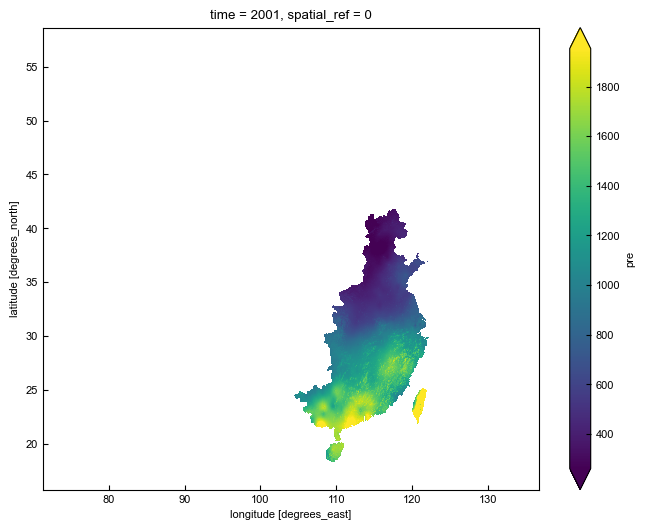

In [9]:
i=0
region=six_region[six_region['name']==regions[i]]#['geometry']
precp=pre.pre#.interp(lon=np.arange(69.75,140.26,0.25),lat=np.arange(14.75,55.26,0.25))
precp.rio.write_crs("epsg:4326", inplace=True)
precp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
cliped = precp.rio.clip(region.geometry.apply(mapping),region.crs,drop=False)
cliped.isel(time=1).plot(robust=True, figsize=(8, 6))

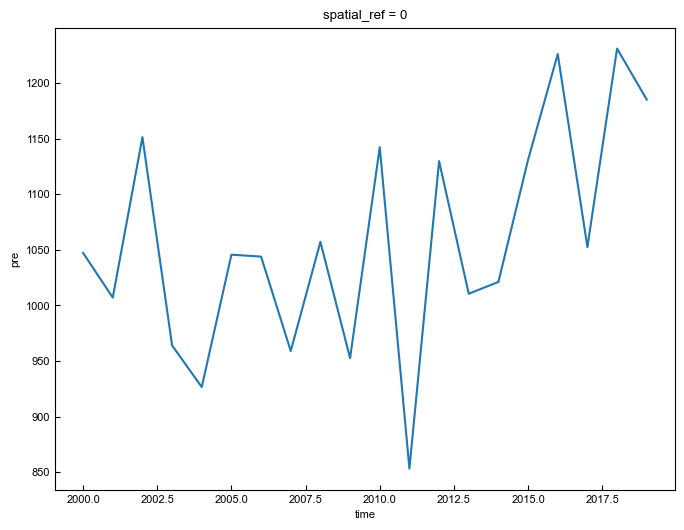

In [12]:
# i=0
# region=six_region[six_region['name']==regions[i]]#['geometry']
# precp=pre.pre#.interp(lon=np.arange(69.75,140.26,0.25),lat=np.arange(14.75,55.26,0.25))
# precp.rio.write_crs("epsg:4326", inplace=True)
# precp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# cliped = precp.rio.clip(region.geometry.apply(mapping),region.crs,drop=False)
cliped.mean(['lat','lon']).plot(figsize=(8, 6))

[411.58334 375.58334 346.08334 418.41666 435.25    459.91666 360.66666
 367.75    422.5     424.08334 403.66666 369.66666 398.25    408.75
 347.58334 385.83334 367.83334 443.25    467.16666 421.75   ]
[1834.4166 2009.5    1884.     1640.0834 1884.0834 1773.1666 1606.25
 1738.8334 2080.9167 1496.3334 1751.8334 1625.5834 1717.0834 1712.3334
 1755.8334 2005.3334 1993.75   1938.5    2005.6666 1529.4166]


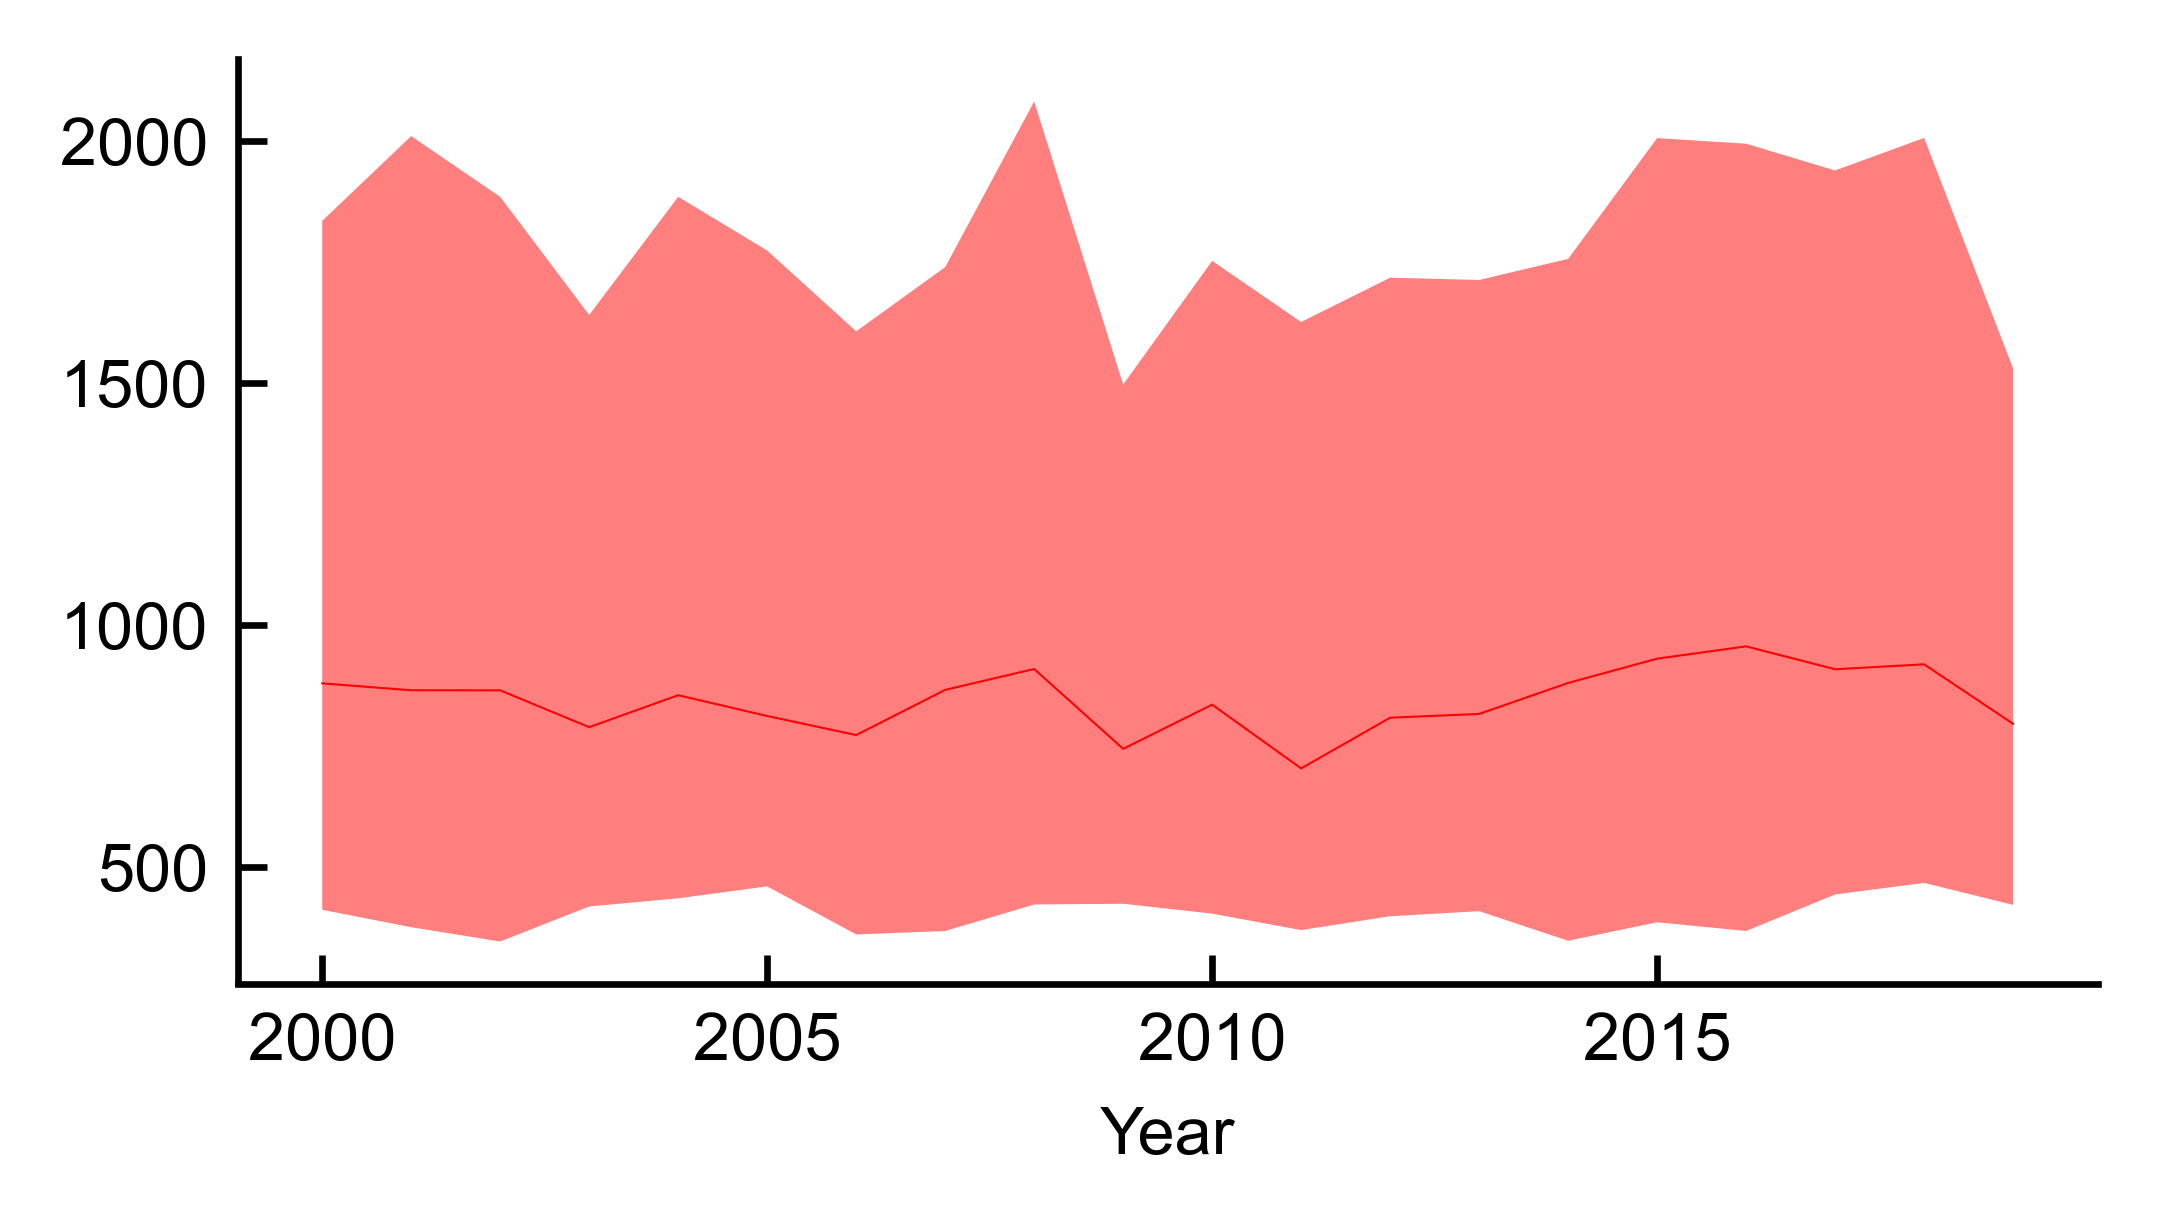

In [28]:
fig = plt.figure(figsize=(4,2), dpi=600)
ax = plt.axes()
xtick=range(2000,2020)
mean=cliped.mean(dim=['lat', 'lon'])
maxP=cliped.max(dim=['lat', 'lon'])
minP=cliped.min(dim=['lat', 'lon'])
print(minP.values)
print(maxP.values)
ax.fill_between(xtick, minP.values, maxP.values,facecolor='red', alpha=0.50)
ax.plot(xtick,meanP,color='red',linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylabel('$A/A^s (\%)$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(2000,2020,5))

In [ ]:
shp = gpd.read_file("./data/china_shp/country1.shp")
shp = shp[shp['CNTRY_NAME']=="China"]

In [ ]:
precp = xr.open_dataset("./data/precip.mon.mean_197901-202105.nc")['precip'].interp(lon=np.arange(69.75,140.26,0.25),lat=np.arange(14.75,55.26,0.25))
precp.rio.write_crs("epsg:4326", inplace=True)
precp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
cliped = precp.rio.clip(shp.geometry.apply(mapping),shp.crs,drop=False)
cliped[0].plot()
plt.show()